# Assignment 2: Keypoint Matching and Image Stitching with SIFT and RANSAC.
---
Name: Aryan Mainkar

ID: 1001844964


## Libraries Used :
---

* matplotlib
* numpy
* PIL
* scipy
* skimage
* random


In [1]:
import numpy as np
import PIL.Image as Image
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from skimage.feature import SIFT, plot_matches
from matplotlib.patches import ConnectionPatch
import random
from skimage.transform import ProjectiveTransform, SimilarityTransform, warp
from scipy.spatial.distance import cdist

## Input source and destination images
---

In [2]:
img1 = input("Enter the name of the destination image: ")
img2 = input("Enter the name of the source image: ")

Enter the name of the destination image:  Rainier1.png
Enter the name of the source image:  Rainier1.png


Convert the read images into an np array and convert them from rgba to rgb

In [3]:
destImgRgb = np.asarray(Image.open(img1).convert('RGB'))
srcImgRgb = np.asarray(Image.open(img2).convert('RGB'))

destImgGray = rgb2gray(destImgRgb)
srcImgGray = rgb2gray(srcImgRgb)

## Keypoint Detection
---

Declaring SIFT constructors for `detector1` for destination image and `detector2` for source image.

Store the keypoints as `keypoint1` and `keypoint2` for destination and source images respectively.


In [4]:
detector1 = SIFT()
detector2 = SIFT()
detector1.detect_and_extract(destImgGray)
detector2.detect_and_extract(srcImgGray)
keypoints1 = detector1.keypoints
descriptor1 = detector1.descriptors
keypoints2 = detector2.keypoints
descriptor2 = detector2.descriptors

Plot and show the keypoints on the grayscale images source and destination
* red keypoints for destination
* blue for source 

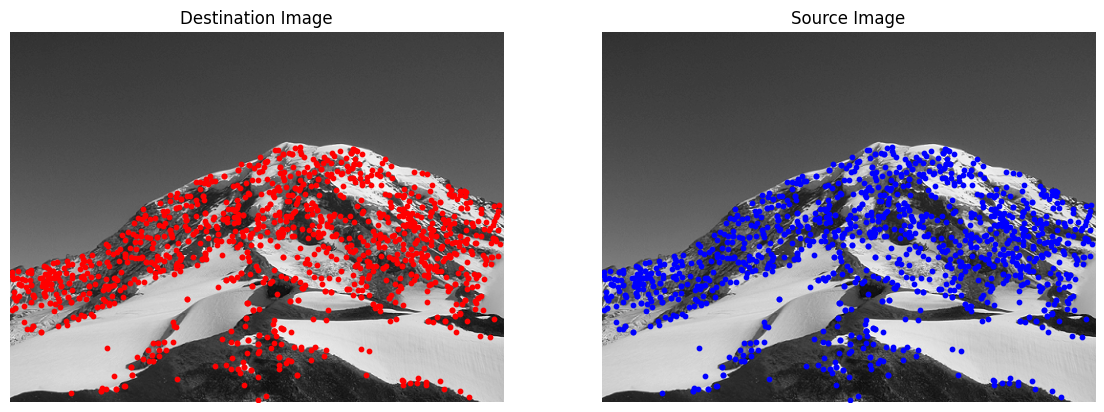

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(14, 9))
ax[0].imshow(destImgGray, cmap='gray')
ax[0].axis('off')
ax[0].set_title('Destination Image')
ax[1].imshow(srcImgGray, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Source Image')
ax[0].scatter(keypoints1[:, 1], keypoints1[:, 0], s=10, c='r')
ax[1].scatter(keypoints2[:, 1], keypoints2[:, 0], s=10, c='b')
plt.show()

## Keypoint Matching
---

Matching function ```matchDescriptor``` that, given two sets of keypoint features, returns a list of indices of matching pairs.

That is, pair $(i,j)$ in the list indicates a match between the feature at index $i$ in the source image with the feature at index $j$ in 

the second image.

In [6]:
def matchDescriptor(descriptor1, descriptor2, ratio):
    dist = cdist(descriptor1, descriptor2)
    index = np.argsort(dist, axis=1)
    matches = []
    for i in range(len(dist)):
        if dist[i, index[i, 0]] < ratio * dist[i, index[i, 1]]:
            matches.append([i, index[i, 0]])
    return np.array(matches)

Calling the `matchDescriptor` function passing `descriptor1`, `descriptor2`, and the `ratio` that is 0.7

In [7]:
matches = matchDescriptor(descriptor1, descriptor2, 0.7)

Printing the matches by using the inbuilt plot-matches function from `SIFT` in `skimage.feature`

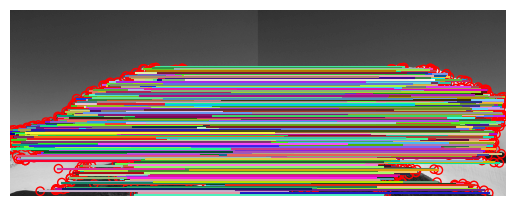

In [8]:
fig, ax = plt.subplots()
plot_matches(ax, destImgGray, srcImgGray, keypoints1, keypoints2, matches, 'r')
ax.axis('off')
plt.show()

## Image Stitching
---


### Estimate Affine Matrix

Function to computer the affine matrix

In [9]:
def computeAffineMatrix(keypoints1, keypoints2, matches):
    source = np.array([keypoints1[m[0], :2] for m in matches])
    destination = np.array([keypoints2[m[1], :2] for m in matches])

    numSamples = source.shape[0]

    sourceAffine = np.concatenate((source, np.ones((numSamples, 1))), axis=1)
    zeroBuffer = np.zeros_like(sourceAffine)
    r1 = np.concatenate((sourceAffine, zeroBuffer), axis=1)
    r2 = np.concatenate((zeroBuffer, sourceAffine), axis=1)

    X = np.empty((r1.shape[0] + r2.shape[0], r1.shape[1]), dtype=r1.dtype)
    X[0::2] = r1
    X[1::2] = r2

    y = destination.ravel()

    affineMatrix = np.linalg.inv(X.T @ X) @ X.T @ y
    affineMatrix = np.concatenate(
        (affineMatrix.reshape(2, 3), np.array([[0, 0, 1]])), axis=0)

    return affineMatrix

### Estimate Projective Matrix

Function to compute the projective matrix

In [10]:
def computeProjectiveMatrix(keypoints1, keypoints2, matches):
    A = []
    b = []
    for i, j in matches:
        x1, y1 = keypoints1[i]
        x2, y2 = keypoints2[j]
        A.append([x1, y1, 1, 0, 0, 0, -x2*x1, -x2*y1])
        A.append([0, 0, 0, x1, y1, 1, -y2*x1, -y2*y1])
        b.append(x2)
        b.append(y2)
    A = np.asarray(A)
    b = np.asarray(b)
    x, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
    H = np.concatenate([x, [1]])
    H = H.reshape((3, 3))
    return H

### RANSAC
---

#### RANSAC Affine

Function to compute the RANSAC with the affine matrix and return the best model and the best inliers

In [11]:
def ransacAffine(matches, keypoints1, keypoints2, min_num, threshold, num_iter):
    best_inlier = []
    best_M = None
    for _ in range(num_iter):
        sampleIndices = random.sample(range(matches.shape[0]), min_num)
        sample = matches[sampleIndices]
        M = computeAffineMatrix(keypoints1, keypoints2, sample)
        inlier = []
        for idx, match in enumerate(matches):
            src = np.array([keypoints1[match[0], :2]])
            dest = np.array([keypoints2[match[1], :2]])
            src_affine = np.concatenate((src, np.ones((1, 1))), axis=1)
            dest_affine = np.concatenate((dest, np.ones((1, 1))), axis=1)
            transformed = M.dot(src_affine.T)
            error = np.linalg.norm(dest_affine.T - transformed) ** 2
            if error < threshold:
                inlier.append(idx)
        if len(inlier) > len(best_inlier):
            best_inlier = inlier
            best_M = M
    return best_M, np.array(best_inlier)

Calling the `ransacAffine` function

Note: Send in the rows and columns inverted

In [12]:
affineMatrix, inliersAffine = ransacAffine(matches, keypoints1[:, ::-1], keypoints2[:, ::-1], 3, 10, 1000)

Plot the matches according to the best model (`affineMatrix`) and the best inlier (`inliersAffine`)

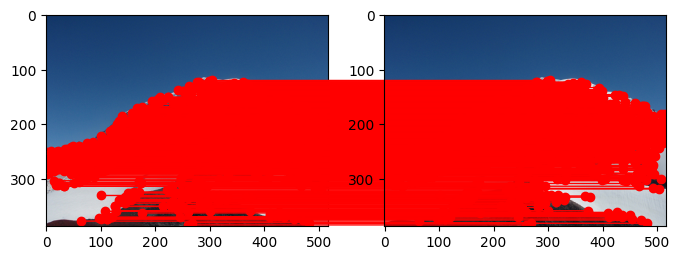

In [14]:
src_best = keypoints2[matches[inliersAffine, 1]][:, ::-1]
dst_best = keypoints1[matches[inliersAffine, 0]][:, ::-1]

fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(destImgRgb)
ax2.imshow(srcImgRgb)

for i in range(src_best.shape[0]):
    coordB = [dst_best[i, 0], dst_best[i, 1]]
    coordA = [src_best[i, 0], src_best[i, 1]]
    con = ConnectionPatch(xyA=coordA, xyB=coordB, coordsA="data", coordsB="data",
                          axesA=ax2, axesB=ax1, color="red")
    ax2.add_artist(con)
    ax1.plot(dst_best[i, 0], dst_best[i, 1], 'ro')
    ax2.plot(src_best[i, 0], src_best[i, 1], 'ro')

plt.show()

#### RANSAC Projective

Function to compute the RANSAC with the projective matrix and return the best model and the best inliers

In [15]:
def ransacProjective(matches, keypoints1, keypoints2, min_num, threshold, num_iter):
    best_inlier = []
    best_M = None
    for _ in range(num_iter):
        sampleIndices = random.sample(range(matches.shape[0]), min_num)
        sample = matches[sampleIndices]
        M = computeProjectiveMatrix(keypoints1, keypoints2, sample)
        inlier = []
        for idx, match in enumerate(matches):
            src = np.array([keypoints1[match[0], :2]])
            dest = np.array([keypoints2[match[1], :2]])
            src_affine = np.concatenate((src, np.ones((1, 1))), axis=1)
            dest_affine = np.concatenate((dest, np.ones((1, 1))), axis=1)
            transformed = M.dot(src_affine.T)
            transformed /= transformed[2]
            error = np.linalg.norm(dest_affine.T - transformed) ** 2
            if error < threshold:
                inlier.append(idx)
        if len(inlier) > len(best_inlier):
            best_inlier = inlier
            best_M = M
    return best_M, np.array(best_inlier)

Calling the `ransacProjective` function

Note: Send in the rows and columns inverted

In [16]:
projectiveMatrix, inliersProjective = ransacProjective(matches, keypoints1[:, ::-1], keypoints2[:, ::-1], 4, 10, 1000)

Plot the matches according to the best model (`projectiveMatrix`) and the best inlier (`inliersProjective`)

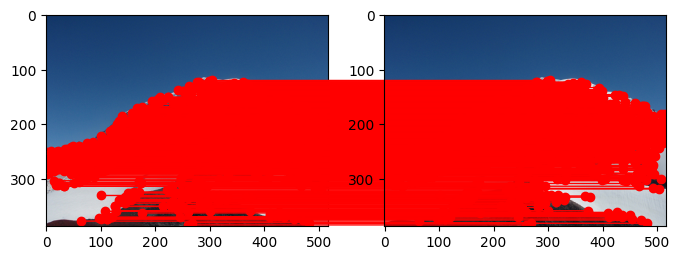

In [17]:
src_best = keypoints2[matches[inliersProjective, 1]][:, ::-1]
dst_best = keypoints1[matches[inliersProjective, 0]][:, ::-1]

fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(destImgRgb)
ax2.imshow(srcImgRgb)

for i in range(src_best.shape[0]):
    coordB = [dst_best[i, 0], dst_best[i, 1]]
    coordA = [src_best[i, 0], src_best[i, 1]]
    con = ConnectionPatch(xyA=coordA, xyB=coordB, coordsA="data", coordsB="data",
                          axesA=ax2, axesB=ax1, color="red")
    ax2.add_artist(con)
    ax1.plot(dst_best[i, 0], dst_best[i, 1], 'ro')
    ax2.plot(src_best[i, 0], src_best[i, 1], 'ro')

plt.show()


### Image Stitching Affine

Function to stitch the image according to the Affine RANSAC and then plotting it using the matplotlib

In [18]:
def stitchingAffine(srcImgRgb, destImgRgb, bestAffine, destImgGray):
    rows, cols = destImgGray.shape
    corners = np.array([
        [0, 0],
        [cols, 0],
        [0, rows],
        [cols, rows]
    ])

    bestAffine = SimilarityTransform(matrix=bestAffine)
    bestAffine(corners)
    all_corners = np.vstack((corners, bestAffine(corners)))
    corner_min = np.min(all_corners, axis=0)
    corner_max = np.max(all_corners, axis=0)
    output_shape = (corner_max - corner_min)
    output_shape = np.ceil(output_shape[::-1]).astype(int)
    print(output_shape)

    offset = SimilarityTransform(translation=-corner_min)
    dst_warped = warp(destImgRgb, offset.inverse, output_shape=output_shape)

    tf_img = warp(srcImgRgb, (bestAffine + offset).inverse,
                  output_shape=output_shape)

    foreground_pixels = tf_img[tf_img > 0]
    dst_warped[tf_img > 0] = tf_img[tf_img > 0]

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.imshow(dst_warped)
    plt.show()

[407 673]


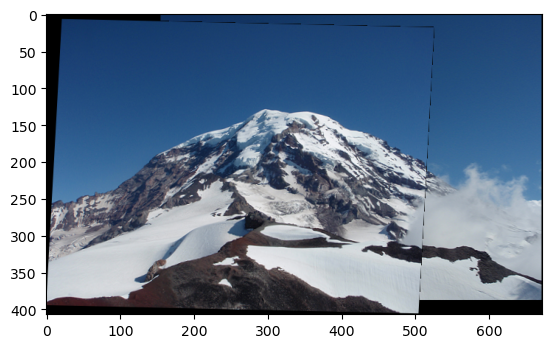

In [38]:
stitchingAffine(destImgRgb, srcImgRgb, affineMatrix, destImgGray)

### Image Stitching Projective

Function to stitch the image according to the Projective RANSAC and then plotting it using the matplotlib

In [19]:
def stitchingProjective(srcImgRgb, destImgRgb, bestProjective, destImgGray):
    rows, cols = destImgGray.shape[:2]
    corners = np.array([
        [0, 0],
        [cols, 0],
        [0, rows],
        [cols, rows]
    ])

    bestProjective = ProjectiveTransform(matrix=bestProjective)
    bestProjective(corners)
    all_corners = np.vstack((corners, bestProjective(corners)))
    corner_min = np.min(all_corners, axis=0)
    corner_max = np.max(all_corners, axis=0)
    output_shape = (corner_max - corner_min)
    output_shape = np.ceil(output_shape[::-1]).astype(int)
    print(output_shape)

    offset = SimilarityTransform(translation=-corner_min)
    dst_warped = warp(destImgRgb, offset.inverse, output_shape=output_shape)

    tf_img = warp(srcImgRgb, (bestProjective + offset).inverse,
                  output_shape=output_shape)
    
    foreground_pixels = tf_img[tf_img > 0]
    dst_warped[tf_img > 0] = tf_img[tf_img > 0]

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.imshow(dst_warped)
    plt.show()

[389 518]


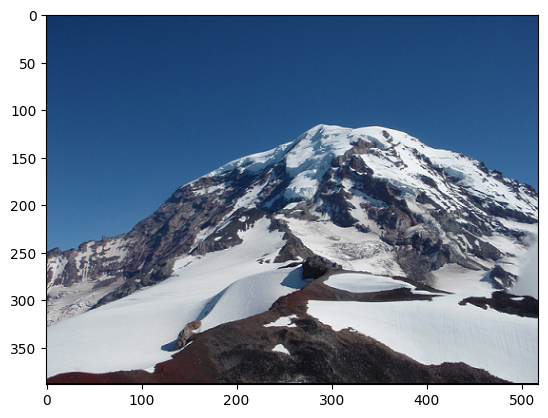

In [20]:
stitchingProjective(destImgRgb, srcImgRgb, projectiveMatrix, destImgGray)

## Observations
---

When comparing Affine and Projective RANSACs I made the following observations: 
---

1)Variability in Results: Both RANSAC methods exhibit variability in their outcomes across different runs, indicating a degree of randomness in their operation.
2)
Distortion Handling: Projective RANSAC demonstrates superior performance in handling distortions compared to Affine RANSAC. It exhibits greater resilience in correcting distortions present in images.3)

Efficiency: Affine transformation tends to be more computationally efficient compared to projective transformation. This observation aligns with information sourced from Googl4)e.

Perspective Handling: Testing the algorithms with personal images revealed that RANSAC struggles to accurately handle images captured from varying perspectives. This limitation suggests a challenge in achieving seamless stitching when dealing with such ima5)ges.

Distortion Variation: While RANSAC proves to be a useful stitching technique, it encounters difficulties in coping with variations in distortions. This limitation implies that the effectiveness of RANSAC may diminish when faced with diverse distortion pat6)terns.

Ease of Implementation: Both Affine and Projective RANSAC implementations are relatively straightforward, requiring minimal parameter tuning for satisfactory results.